# Real Estate Analysis
The goal of this project is to analyse rental prices in central London and see if a model can be built to predict the rental price of a flat based on its features. 
I am going to scrape [Zoopla](https://www.zoopla.co.uk) to get the features of flats on the rental market with up to 5 bedrooms. The data that will be extracted is:
* ```price```: rent per month in £.
* ```number_of_rooms```: the number of bedrooms in the flat.
* ```number_of_bathrooms```
* ```nearest_tube```: the distance in miles to the nearest tube
* ```postcode```: the area of central London in which the flat is located

In [1]:
#imports
import requests
from bs4 import BeautifulSoup as soup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

## Gathering the data
In this section, the data will be scraped from Zoopla using the BeautifulSoup and requests libraries. 

In [2]:
#creating a get request for the relevant page. 
url  = 'https://www.zoopla.co.uk/to-rent/property/central-london/?beds_max=5&price_frequency=per_month&q=Central%20London&results_sort=newest_listings&search_source=home'
response = requests.get(url)
#checking status code, 200 = OK
response.status_code

200

In [3]:
data  = soup(response.content, 'lxml')

In [4]:
#create empty lists that will be filled with scraped data
prices, number_of_rooms, number_of_bathrooms, nearest_tube, postcodes = [], [], [], [], []



for page in range(0,30):  #number of pages on webiste to scrape. Each page has the listing info for 25 properties. 
    data = soup(requests.get(url + str(page)).content, "lxml")
    
    
    
    #price
    for line in data.findAll(
        "div", {"class": "css-1e28vvi-PriceContainer e2uk8e7"}
    ):
        price = line.get_text(strip=True)
        price = float(re.sub(r"[^\d]", "", price)) #regex
        prices.append(price)
     
    
    
    #number of rooms
    for line in data.findAll('h2', {'class': 'css-vthwmi-Heading2-StyledAddress e2uk8e13'}):
        rooms = line.get_text().split(' ')[0]
        #Certain properties are listed as 'Studios' so they only have one room. This raises a ValueError when 
        #converting first character to int as it can sometimes be str. Use try/except block to circumvent. 
        try: 
            rooms = int(rooms)
        except ValueError:          
            rooms = 1
        number_of_rooms.append(rooms)
    
    
    #number of bathrooms
    
    #cannot use 'p' tag directly as there can be up to 3 of them with the same class (one for bedrooms,
    # one for bathrooms and one for reception rooms)
    bathroom_tags = data.findAll('div', {'class': 'css-58bgfg-WrapperFeatures e2uk8e14'} )
    for line in bathroom_tags:
        #find all the 'p' tags within the 'div' and select the second one (which corresponds to number of bathrooms)
        bathroom_finder = line.findAll('p', {'class': 'css-r8a2xt-Text eczcs4p0'} )
        try:
            number_of_bathrooms.append(int(bathroom_finder[1].get_text()))
        #if IndexError is raised append null value to list as that means there is no info on number of bathrooms. 
        except IndexError:
            number_of_bathrooms.append(np.NaN)
            
            
        
    
    #nearest tube
    for line in data.findAll('div', {'class': 'css-braguw-TransportWrapper e2uk8e28'}):
        nearest_tube.append(float(line.get_text().split(' ')[0]))
        
        
    
    
    #postcode
    #Every two other 'p' tags with this class are not relevant and do not contain the postcode so we can skip them. 
    for line in data.findAll('p', {'class': 'css-nwapgq-Text eczcs4p0'})[::3]:
        postcode = line.get_text()
        #regex: not matching just digits or just capital, capital letters and digits minimum 2
        postcode = re.search(r"(?!\d+\b)(?![A-Z]+\b)[A-Z\d]{2,}", postcode).group() 
        postcodes.append(postcode)
        
        
        
        
        
        

print(prices, number_of_rooms, number_of_bathrooms, nearest_tube, postcodes)
        

[2275.0, 2000.0, 1842.0, 2000.0, 2167.0, 2297.0, 1998.0, 3878.0, 2710.0, 2578.0, 2275.0, 2200.0, 6933.0, 3012.0, 1300.0, 3033.0, 3033.0, 3293.0, 2167.0, 2708.0, 2708.0, 9317.0, 1950.0, 1668.0, 3900.0, 2275.0, 2000.0, 1842.0, 2000.0, 2167.0, 2297.0, 1998.0, 3878.0, 2710.0, 2578.0, 2275.0, 2200.0, 6933.0, 3012.0, 1300.0, 3033.0, 3033.0, 3293.0, 2167.0, 2708.0, 2708.0, 9317.0, 1950.0, 1668.0, 3900.0, 2275.0, 2000.0, 1842.0, 2000.0, 2167.0, 2297.0, 1998.0, 3878.0, 2710.0, 2578.0, 2275.0, 2200.0, 6933.0, 3012.0, 1300.0, 3033.0, 3033.0, 3293.0, 2167.0, 2708.0, 2708.0, 9317.0, 1950.0, 1668.0, 3900.0, 2275.0, 2000.0, 1842.0, 2000.0, 2167.0, 2297.0, 1998.0, 3878.0, 2710.0, 2578.0, 2275.0, 2200.0, 6933.0, 3012.0, 1300.0, 3033.0, 3033.0, 3293.0, 2167.0, 2708.0, 2708.0, 9317.0, 1950.0, 1668.0, 3900.0, 2275.0, 2000.0, 1842.0, 2000.0, 2167.0, 2297.0, 1998.0, 3878.0, 2710.0, 2578.0, 2275.0, 2200.0, 6933.0, 3012.0, 1300.0, 3033.0, 3033.0, 3293.0, 2167.0, 2708.0, 2708.0, 9317.0, 1950.0, 1668.0, 3900.0,

In [5]:
print(len(prices), len(number_of_rooms), len(number_of_bathrooms), len(nearest_tube), len(postcode))

750 750 750 750 3


Our columns each contain 750 values. However, the ```number_of_bathroom``` list has several missing values. 


## Cleaning 
In the section we are going to clean the data and construct the dataframe which will be used for the exploratory data analysis and model building. 

In [6]:
#Creating a pandas dataframe by zipping lists together;
df = pd.DataFrame(list(zip(prices, number_of_rooms, number_of_bathrooms, nearest_tube, postcodes)), columns =['price', 'number_of_rooms', 'number_of_bathrooms', 'nearest_tube', 'postcode'])
df

,price,number_of_rooms,number_of_bathrooms,nearest_tube,postcode
0,2275.0,1,1,0.2,W1J
1,2000.0,1,1,0.3,EC3R
2,1842.0,1,1,0.5,SW1V
3,2000.0,1,1,0.1,EC1M
4,2167.0,2,2,0.1,EC1M
...,...,...,...,...,...
745,2708.0,1,1,0.3,W1J
746,9317.0,4,4,0.2,W1U
747,1950.0,1,1,0.2,W1F
748,1668.0,1,1,0.2,SW1P


In [7]:
#drop null values 
df.dropna(inplace = True)

There are 180 null values on our dataset. Since we already have 750 observations, we can drop these rows to simplify the cleaning stage.

### About London postcodes
We see that the postcode column is a categorial variable with too many levels. This will make the model harder to build and trickier to interpret. However there is a way around this. 

Postcodes in [Greater London](https://en.wikipedia.org/wiki/London_postal_district) always begin with up to 2 letters. These letteres correspond to the location of the area with respect for the center. For example, postcodes that begin with 'NW' pertain to northwest London districts. By using the map of Central London below, we see that our post codes can be split into 3 areas: west, east and southwest.  ![image](london_postcodes.pdf) 

In [8]:
df.loc[(df.postcode.str.startswith('W')),'postcode']='west'
df.loc[(df.postcode.str.startswith('E')),'postcode']='east'
df.loc[(df.postcode.str.startswith('S')),'postcode']='south_west'

In [9]:
#rename postcode column
df = df.rename(columns = {'postcode': 'area'})

It could also be useful to convert the prices to euros and the distances to kilometers. 
Let's get the current pound/euro exchange rate and write a function which converts an amount from pounds to euros. 

In [10]:
exchange_url = 'https://www.xe.com/currencyconverter/convert/?Amount=1&From=GBP&To=EUR'
response = requests.get(exchange_url)
page = soup(response.content, 'lxml')
exchange_rate = float(page.find('p', {'class': 'result__BigRate-sc-1bsijpp-1 iGrAod'}).get_text().split(' ')[0])

def to_eur(amount): 
    return int(amount*exchange_rate)

def to_km(dist):
    rate = 1.6093 
    return dist*rate

In [11]:
#apply these functions to the price and distance columns. 
df.price = df.price.apply(lambda x: to_eur(x))
df.nearest_tube = df.nearest_tube.apply(lambda x: to_km(x))

In [12]:
df

,price,number_of_rooms,number_of_bathrooms,nearest_tube,area
0,2643,1,1,0.32186,west
1,2323,1,1,0.48279,east
2,2140,1,1,0.80465,south_west
3,2323,1,1,0.16093,east
4,2517,2,2,0.16093,east
...,...,...,...,...,...
745,3146,1,1,0.48279,west
746,10825,4,4,0.32186,west
747,2265,1,1,0.32186,west
748,1938,1,1,0.32186,south_west


## Exploratory Data Analysis 
In this section, we will explore the relationship between the different covariates and the ```price``` to draw insights and potentially build a model. 

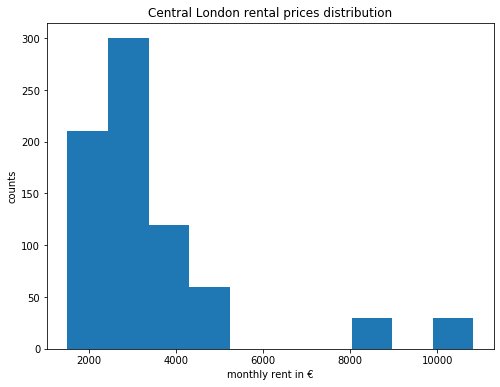

In [13]:
plt.figure(figsize = [8,6]);
plt.hist(df['price']);
plt.xlabel('monthly rent in €');
plt.ylabel('counts');
plt.title('Central London rental prices distribution');

In [14]:
print(df['price'].mean(), df['price'].median())

3403.52 2668.0


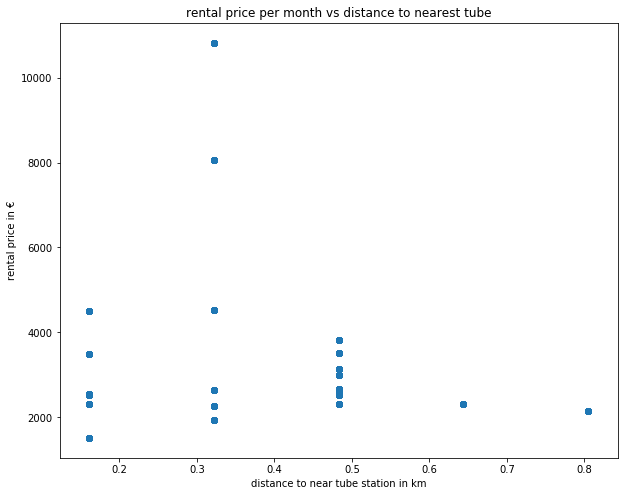

In [15]:
plt.figure(figsize = (10,8));
plt.scatter(df['nearest_tube'], df['price'], marker = 'o');
plt.title('rental price per month vs distance to nearest tube');
plt.xlabel('distance to near tube station in km');
plt.ylabel('rental price in €');

Overall, this plot suggests that on average, the prices are somewhat linearly decreasing as the distance to the nearest tube station increases. 

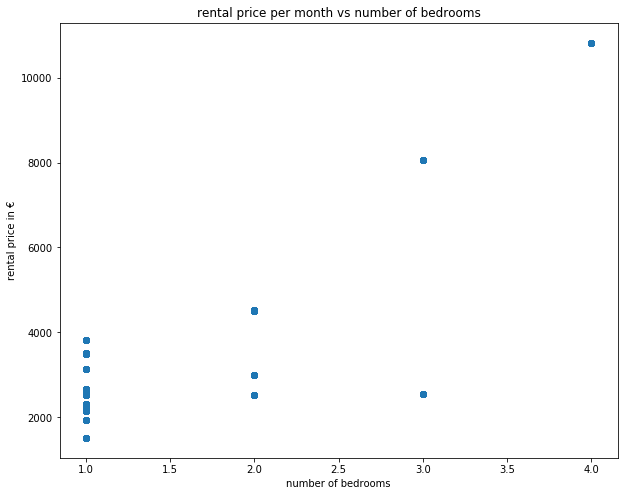

In [16]:
plt.figure(figsize = (10,8));
plt.scatter(df['number_of_rooms'], df['price']);
plt.title('rental price per month vs number of bedrooms');
plt.xlabel('number of bedrooms');
plt.ylabel('rental price in €');

This graph indicates that the rental price scales linearly with the number of bedrooms. 

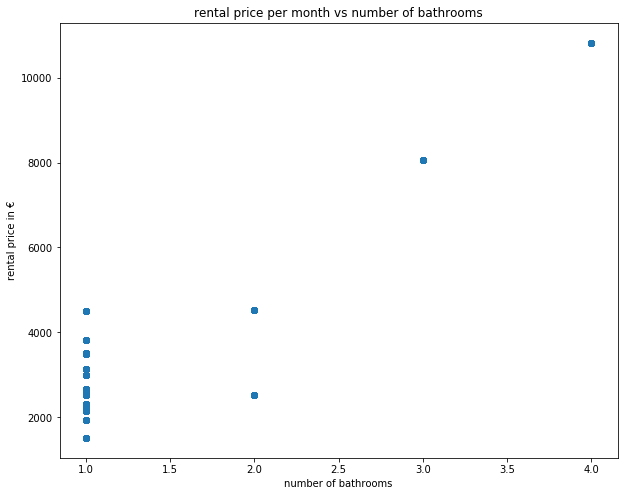

In [17]:
plt.figure(figsize = (10,8));
plt.scatter(df['number_of_bathrooms'], df['price'])
plt.title('rental price per month vs number of bathrooms');
plt.xlabel('number of bathrooms');
plt.ylabel('rental price in €');

We see that the rental price scales in a linear fashion with the number of bathrooms in the flat. 

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


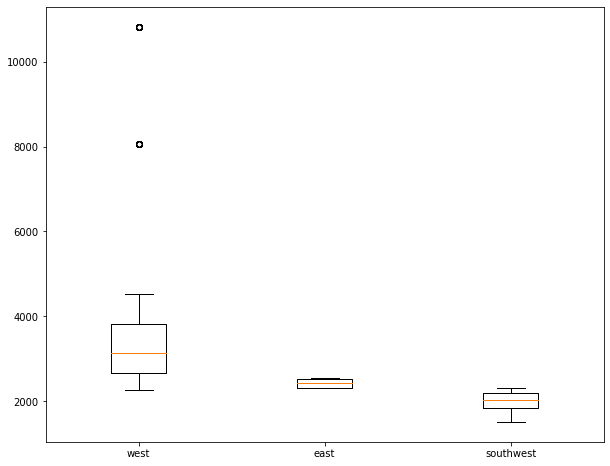

In [18]:
plt.figure(figsize = [10,8])
plt.boxplot([df[df['area']== 'west']['price'], df[df['area']== 'east']['price'], df[df['area']== 'south_west']['price']], 
            labels = ['west', 'east', 'southwest']);

We see that overall, that on average, west London has the highest rental prices and east London has the lowest rental prices.  

## Linear Regression (ordinary least squares) 

### Concept

The idea is to find a way to express the response variable in the following way:  $$\begin{pmatrix} y_1 \\.\\.\\.\\ y_n \end{pmatrix}= \begin{pmatrix} 1 & x_{11} & \ldots & x_{1p} \\ . & .\\.&&.\\.&&&.\\ 1 & x_{n1} & \ldots & x_{np}\end{pmatrix} \begin{pmatrix} \beta_0 \\.\\.\\ \beta_r \end{pmatrix} + \begin{pmatrix} \epsilon_1 \\.\\.\\.\\ \epsilon_n \end{pmatrix}$$

Or $$y_i = \beta_0 + \epsilon_i + \sum_{j =1}^p \beta_{j} X_{ij}$$

For each observation $i$ and each of the $p$ covariates. 

The parameter vector is determined using the ordinary least squares vector. $$ \hat \beta = \arg \min_{\beta \in \mathbb R^p} \sum_{i=1}^n \left( y_i - \sum_{j=1}^p x_{ij} \beta_j \right)^2$$

### Assumptions

The linear model only 'works' under certain assumptions that we have to make about our data. Namely: 

* Assumption of linearity: we're assuming that the expected value of the $i$th response can be written as a linear combination of the predictors.
* There is little to no multicollineartiy between the variables, which implies that the matrix $(\mathbf X^T \mathbf X)$ is invertible. 
* Assumption of independence: the observations are independent of one another. 
* Assumption of homoscedacity: the variance of the residuals is constant.
* Assumption of multivariate normality: the residuals are normally distributed: $\epsilon_i \sim N(0, \sigma^2)$ (exogeneity). 


### Preprocessing

In [19]:
df[['south_west', 'west']] = pd.get_dummies(df['area'], drop_first=True)
#pd.get_dummies(df['area'])
df.drop(columns='area', inplace = True)

In [20]:
#Set response vector
y = df['price']

#set design matrix
X = df.drop(columns = 'price')

#Add intercept
X = sm.add_constant(X)

#split data into training and testing sets
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=0 )


### Model building and testing

In [21]:
model = sm.OLS(y_train, X_train).fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1378.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        14:51:47   Log-Likelihood:                -5258.6
No. Observations:                 675   AIC:                         1.053e+04
Df Residuals:                     669   BIC:                         1.056e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -991.6068     92.425    -10.729      0.000   -1173.084    -810.129
number_of_rooms       582.9333     53.902     10.815      0.000     477.095     688.771
number_of_bathrooms  1819.5353     57.297     31.756      0.000    1707.032    1932.039
nearest_tube          563.9258    158.577      3.556      0.000     252.557     875.295
south_west            286.6258     89.169      3.214      0.001     111.540     461.711
west                 1423.1675     68.223     20.860      0.000    1289.210    1557.125
==============================================================================
Omnibus:                       24.562   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.131
Skew:                          -0.363   Prob(JB):                     2.58e-05
Kurtosis:                       2.527   Cond. No.                         19.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Coefficient of determination**

Our model returns a high coefficient of determination $R^2$. $$R^2 = 1 - \frac{ \sum_{i=1}^n \left (y_i - \mathbb E(y_i) \right)^2}{\sum_{i=1}^n (y_i - \bar y )^2}$$ 

Is the complement of the ratio between the residual sum of squares and the total sum of squares (which is proportional to $Var(y)$). (Too) much importance is often placed around this value which can be interpreted as the percent variability in $y$ accounted for by the model. R-squared does not measure goodness of fit, therefore, it is also important to look at other quantities in the model output. 

**ANOVA** 

The Analysis of Variance for regression allows us to test the following hypotheses: $$H_0: \{\beta_i \}_{i=1}^n =0$$ $$H_1: \{\beta_i \}_{i=1}^n \neq 0$$

This test is to determine whether the *nested* model with just the intercept  is a better fit for the data than the one with all the covariates inculded, $DF_{full}$. The number of degrees of freedom is: $DF = n -(p+1)$. We use an F-statistic: 

$$F = \frac{(RSS_{nest} -RSS_{full})/(DF_{nest} -DF_{full})} {RSS_{full}/DF_{full}} \sim F_{DF_{nest}-DF_{full}, DF_{full}}$$

The model output returns a very low p-value which indicates that we have evidence to reject the null hypothesis that the model with just the intercept is 'better'. 

**Testing Single Regression Coefficients**


The idea here is to compare two models: one without a given covariate $\mathbf x_i$ and one with it in (the idea of other covariates being present in the null hypothesis is very important): $$H_0: \beta_i =0,$$ $$H_1: \beta_i \neq 0, i \in [1,p]$$

Which is done via a two-tailed T-test. We see all our covariates have low p-values associated with them which indicates that they are *statistically significant*.


**Durbin-Watson**

Departures from the assumption we make that $\epsilon_i \sim N(0, \sigma^2)$ have consequences on hypothesis test and confidence intervals. The Durbin-Watson test allows us to check if the error terms are independent. $$d= \frac{ \sum_{i=2}^n (\epsilon_i -\epsilon_{i-1})^2 }{\sum_{i=1}^n \epsilon_i^2}$$

This value always falls between 0-4 and a value of 2 indicates no serial correlation. The Durbin-Watson value returned by our model is very close to 2. 

**Conclusion** 

Though we have not examined all the values outputted by our model, the ones we have studied indicate that our model provides a good fit for our data and that overall, none of the assumptions we have made seem to be violated. 

### Model testing


In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred, y_test

(474    5418.003124
 113    2924.781900
 266    3106.287056
 31     2060.497996
 548    1878.992840
           ...     
 536    2667.481041
 293    3106.287056
 367    3106.287056
 710    3106.287056
 745    3106.287056
 Length: 75, dtype: float64,
 474    4531
 113    3499
 266    3524
 31     2321
 548    1938
        ... 
 536    2556
 293    2517
 367    3826
 710    2643
 745    3146
 Name: price, Length: 75, dtype: int64)